### Load pretrained classifier model

In [2]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

import tensorflow as tf
import numpy as np

base_model = VGG16(weights="imagenet")

print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Start off with a test prediction on a single image (elephant)

This should correctly identify the elephant as an elephant (tusker is a more general category that includes elephants).

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


img_path = 'images/elephant.jpeg'
# img_path = 'images/highway.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = base_model.predict(x)

decoded = decode_predictions(preds, top=5)[0]

print('Predicted:')
for i, p in enumerate(decoded):
    print(f" {i+1}: p = {p[2]:.4f}, class = \"{p[1]}\"")


1/1 [==============================] - 0s 232ms/step
Predicted:
 1: p = 0.4784, class = "tusker"
 2: p = 0.4560, class = "African_elephant"
 3: p = 0.0656, class = "Indian_elephant"
 4: p = 0.0000, class = "water_buffalo"
 5: p = 0.0000, class = "triceratops"


### Show the activations of each layer of the model

Note: layers with a "depth" greater than 3 are averaged across the depth dimension to make them possible to visualize.

Each layer is run individually using the previous layer's output, and the new output is kept for the next iteration.
This is done instead of just re-running the model with more and more layers each time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input_1 (1, 224, 224, 3)


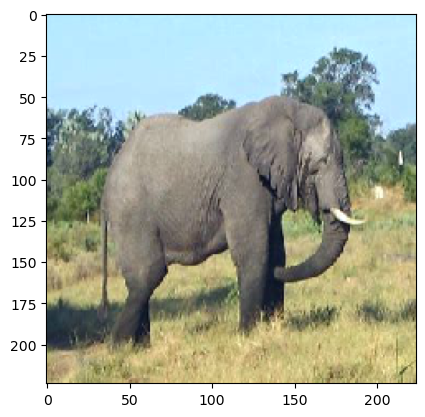

block1_conv1 (1, 224, 224, 64)


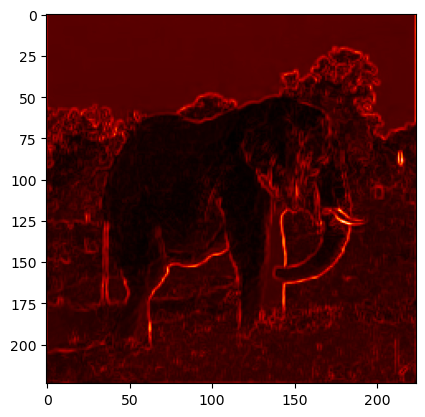

block1_conv2 (1, 224, 224, 64)


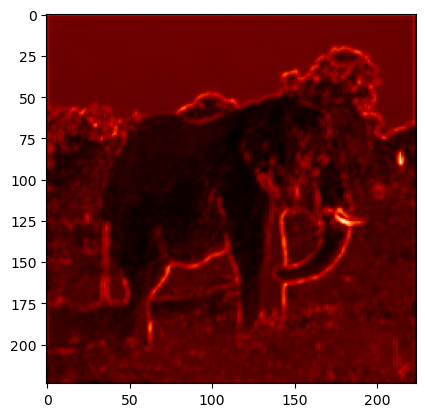

block1_pool (1, 112, 112, 64)


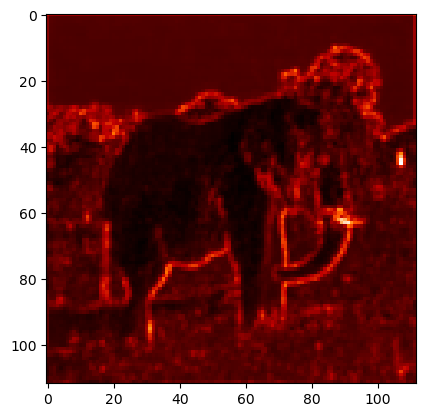

block2_conv1 (1, 112, 112, 128)


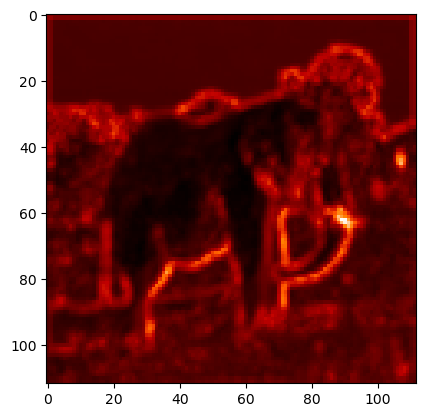

block2_conv2 (1, 112, 112, 128)


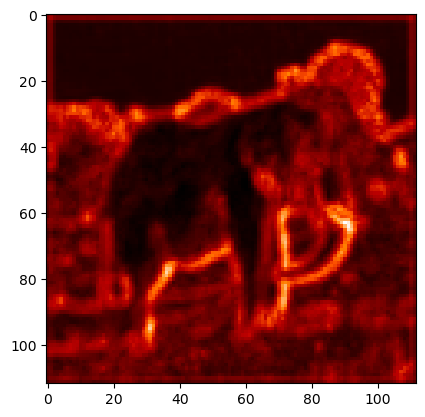

block2_pool (1, 56, 56, 128)


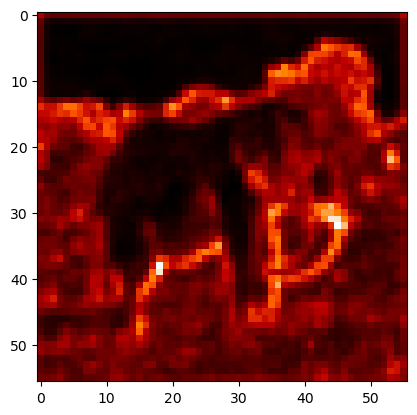

block3_conv1 (1, 56, 56, 256)


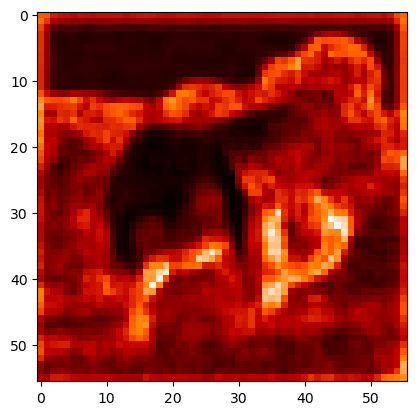

block3_conv2 (1, 56, 56, 256)


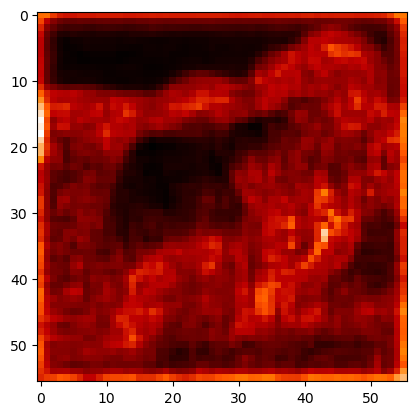

block3_conv3 (1, 56, 56, 256)


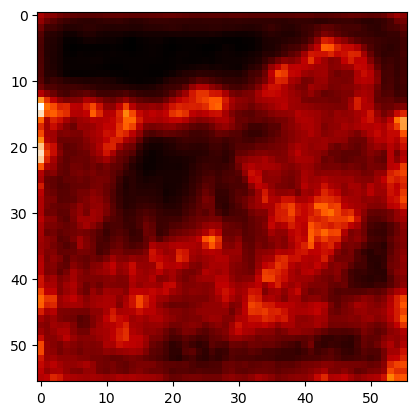

block3_pool (1, 28, 28, 256)


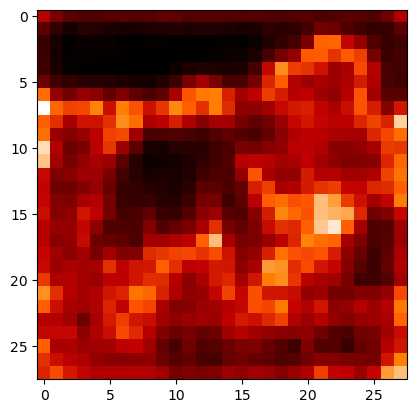

block4_conv1 (1, 28, 28, 512)


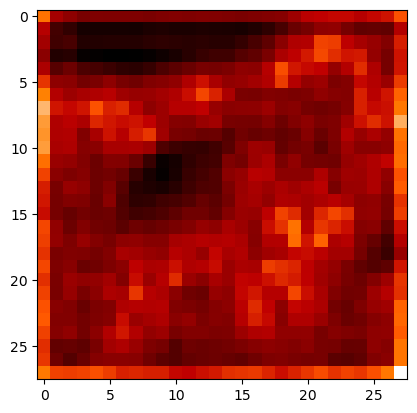

block4_conv2 (1, 28, 28, 512)


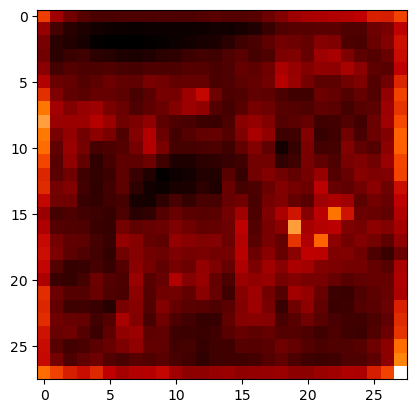

block4_conv3 (1, 28, 28, 512)


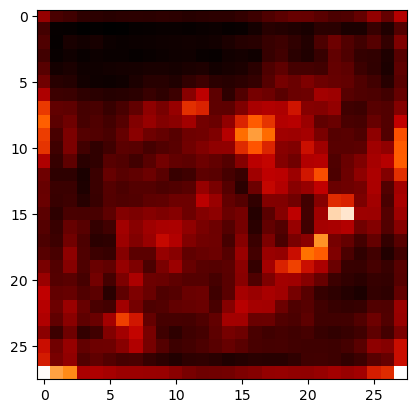

block4_pool (1, 14, 14, 512)


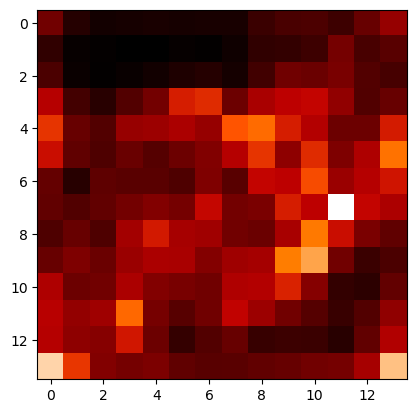

block5_conv1 (1, 14, 14, 512)


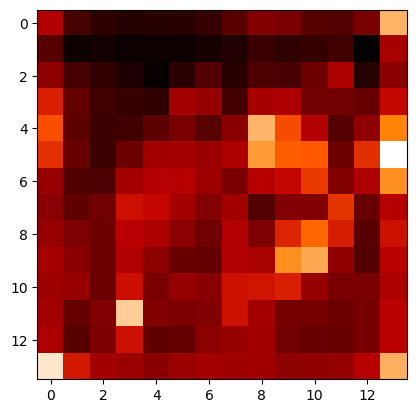

block5_conv2 (1, 14, 14, 512)


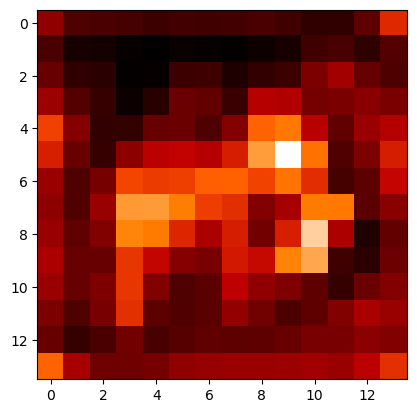

block5_conv3 (1, 14, 14, 512)


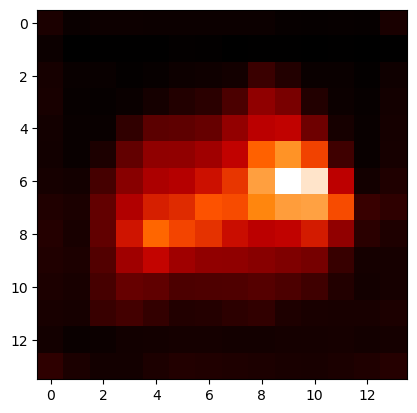

block5_pool (1, 7, 7, 512)


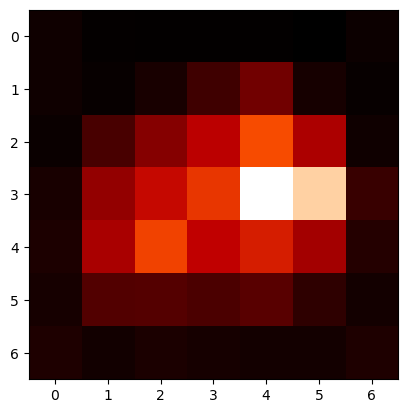

flatten (1, 25088)


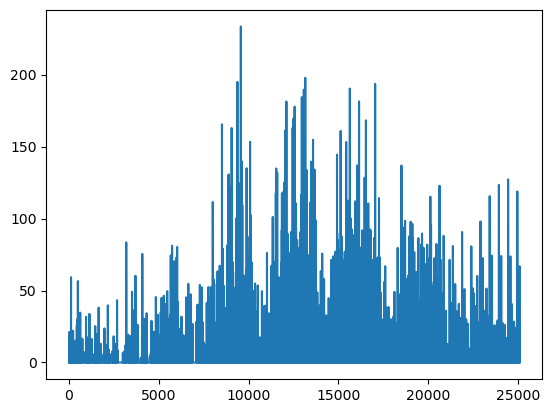

fc1 (1, 4096)


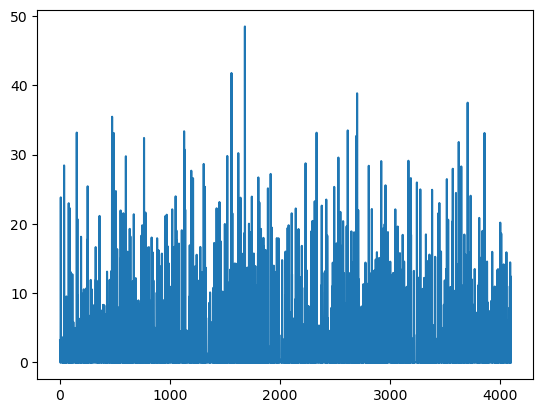

fc2 (1, 4096)


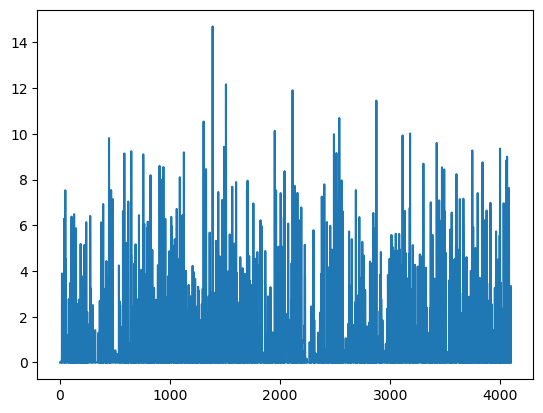

predictions (1, 1000)


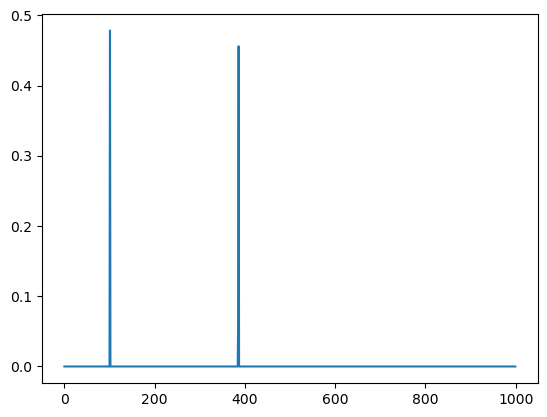

Predicted:
 1: p = 0.4784, id = n01871265, class = "tusker"
 2: p = 0.4560, id = n02504458, class = "African_elephant"
 3: p = 0.0656, id = n02504013, class = "Indian_elephant"
 4: p = 0.0000, id = n02408429, class = "water_buffalo"
 5: p = 0.0000, id = n01704323, class = "triceratops"


In [4]:
# start with the input image
previous_output = x

outputs = []

# for each layer, get the output, plot each layer in a subplot and save the new output for the next layer
for layer in base_model.layers:
    
    output = layer(previous_output)
    outputs.append(output)
    
    previous_output = output
    print(layer.name, output.shape)

    # if the output is at least 4D (batch_size, x, y, channels), plot the output as an image
    if len(output.shape) == 4:
        # if the output has 3 channels, assume it's an image with RGB channels
        if output.shape[3] == 3:
            # plot the image
            # note: vgg16 converts the image to BGR format, and centers the values around 0, 
            # so we have to reverse the channel order "::-1" and shift everything by 0.5 to get positive values (some still get clipped but it works well enough)
            plt.imshow(output[0, :, :, ::-1]/255 + 0.5)
        else:
            # average the channels (usually there are 64) and display the heatmap
            plt.imshow(np.average(output[0, :, :, :], axis=2), cmap='gist_heat')
        plt.show()
    else:
        # not an image, so plot as a graph
        plt.plot(output[0])
        plt.show()


decoded = decode_predictions(np.array(output), top=5)[0]

print('Predicted:')
for i, p in enumerate(decoded):
    print(f" {i+1}: p = {p[2]:.4f}, id = {p[0]}, class = \"{p[1]}\"")
    

## Crudely apply an attention heatmap to the original image

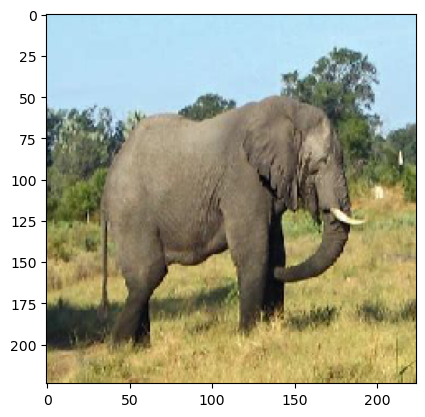

(224, 224, 3)
0.0 1.0


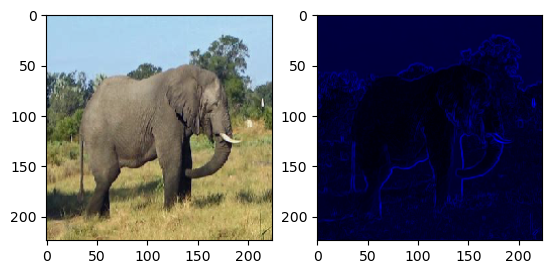

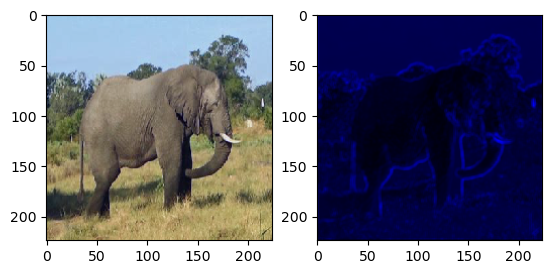

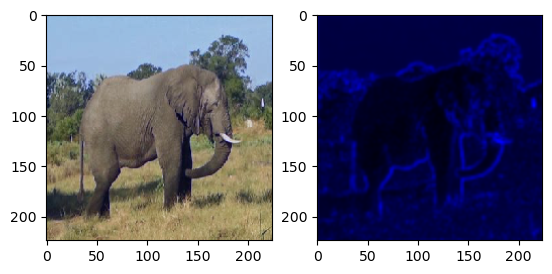

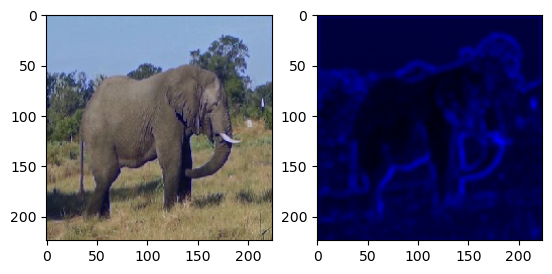

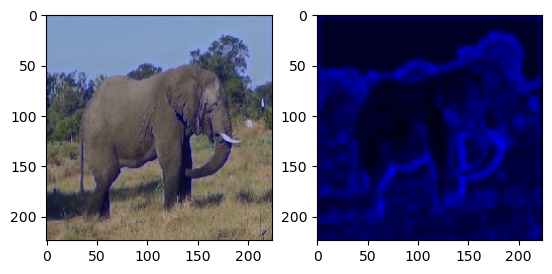

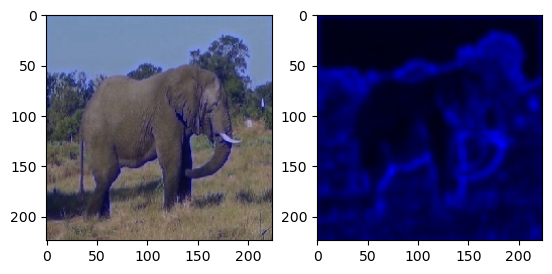

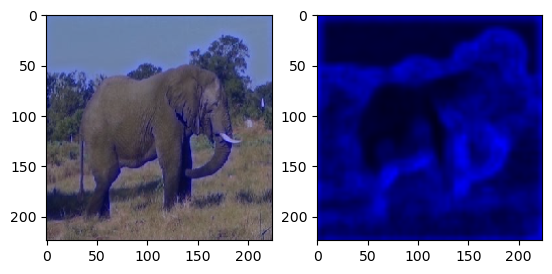

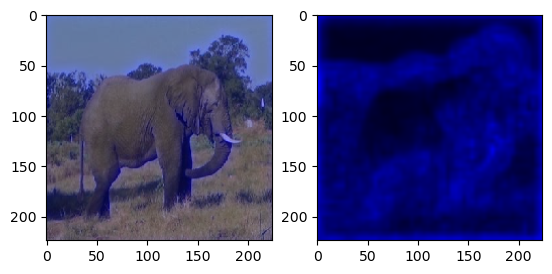

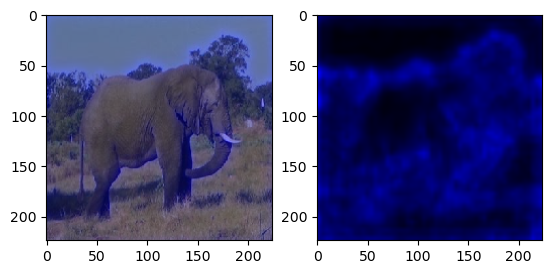

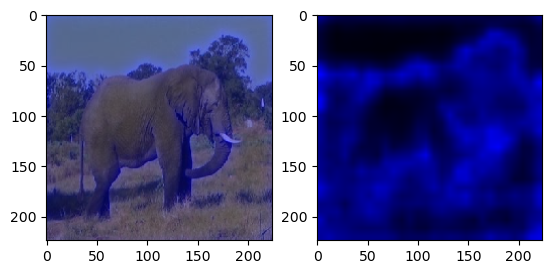

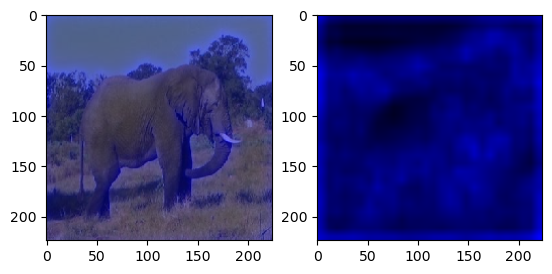

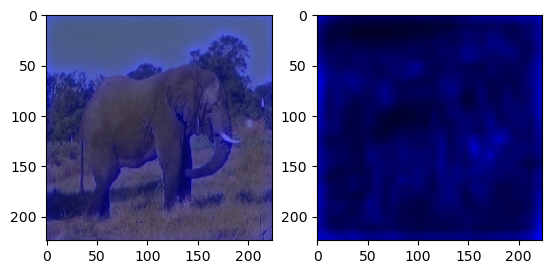

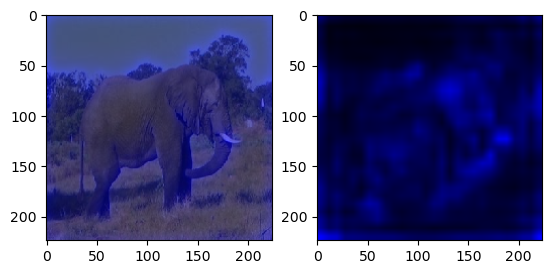

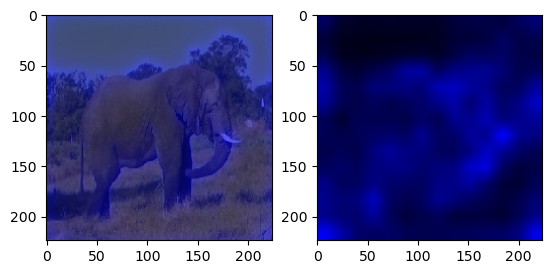

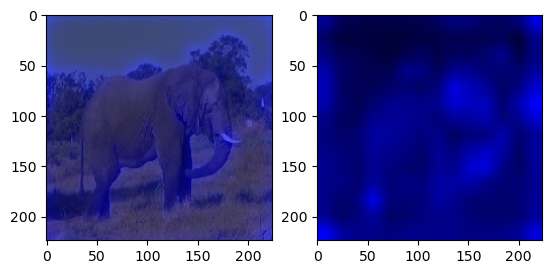

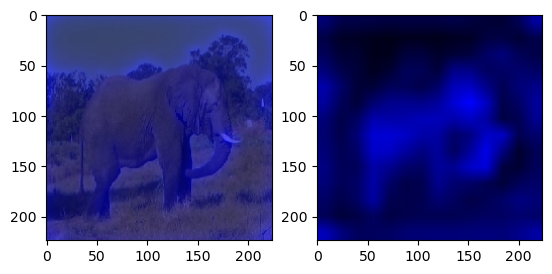

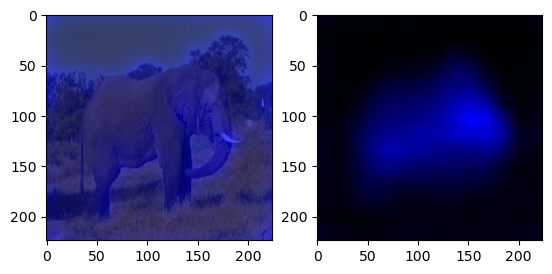

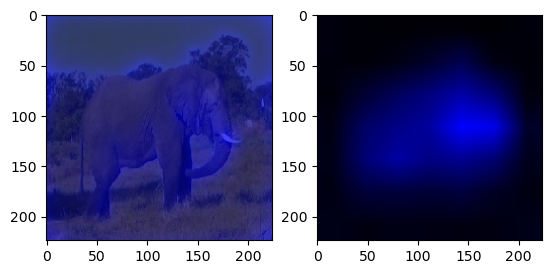

In [43]:
resized_outputs = []

# skip first layer as it's the input image
for i, output in enumerate(outputs[1:]):
    if len(output.shape) == 4:
        resized = tf.image.resize(output, (224, 224))
        resized = np.average(resized[0, :, :, :], axis=2)
        # convert from (224, 224) to (224, 224, 3) by duplicating the grayscale channel
        resized = np.stack((resized * 0, resized * 0, resized), axis=2)

        # scale the values to be between 0 and 1
        # get min and max values
        min_val = np.min(resized)
        max_val = np.max(resized)

        # scale the values
        resized = (resized - min_val) / (max_val - min_val)

        resized_outputs.append(resized)
    else:
        break


img = np.array(img)
plt.imshow(img)
plt.show()

print(img.shape)

img_with_heatmaps = img.copy()

# convert the image to float32
img_with_heatmaps = img_with_heatmaps.astype('float32') / 255

print(np.min(img_with_heatmaps), np.max(img_with_heatmaps))

# apply each heatmap to the image and plot the result
for resized in resized_outputs:
    # add the heatmap to the image with 10% transparency
    img_with_heatmaps += resized * 0.1
    
    # scale the values to be between 0 and 1
    # get min and max values
    min_val = np.min(img_with_heatmaps)
    max_val = np.max(img_with_heatmaps)

    # scale the values
    img_with_heatmaps = (img_with_heatmaps - min_val) / (max_val - min_val)

    plt.subplot(121)
    plt.imshow(img_with_heatmaps)
    plt.subplot(122)
    plt.imshow(resized)

    plt.show()
    

